In [304]:
import torch,sys,os
from omegaconf import OmegaConf
from PIL import Image, ImageDraw
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from base.data import load_data
from base.utils import instantiate_from_config
from debias_train.main import PLModel
from torchvision import transforms
from torch.utils.data import DataLoader

In [305]:
config_path = '/home/wht/multimodal_brain/src/tasks/base/configs/debias_train.yaml'
config = OmegaConf.load(config_path)
config['ksize'] = None
config['sigmaX'] = None

train_loader, test_loader = load_data(config)
train_loader = DataLoader(train_loader.dataset, batch_size=config['data']['train_batch_size'], shuffle=False, drop_last=False, num_workers=64, pin_memory=True)

model = {}
for k,v in config['models'].items():
    model[k] = instantiate_from_config(v)
pl_model = PLModel(model,config,test_loader)

/home/wht/multimodal_brain/src/tasks/base/data.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(data_path)
/home/wht/multimodal_brain/src/tasks

init test_dataset success
init train_dataset success


In [306]:
ckpt_path = "/home/wht/multimodal_brain/src/tasks/exp/saliency/['sub-08']_[10, 15]_[4, 9]/checkpoints/epoch=14-step=255-v3.ckpt"
pl_model.load_state_dict(torch.load(ckpt_path)['state_dict'])
pl_model.cuda()
pl_model.eval()

/tmp/ipykernel_1756559/4046442764.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_model.load_state_dict(torch.load(ckpt_path)['state_dict'])


PLModel(
  (eeg): EEGProjectLayer(
    (model): Sequential(
      (0): Linear(in_features=13600, out_features=1024, bias=True)
      (1): ResidualAdd(
        (f): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.3, inplace=False)
        )
      )
      (2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (debias): Direct(
    (model): Identity()
  )
  (criterion): ClipLoss()
  (vlmodel): CLIP(
    (visual): ModifiedResNet(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): 

In [307]:
device = next(pl_model.eeg.parameters()).device
for i,batch in enumerate(train_loader):
    eeg, label, img_path,img, img_features, text, text_features, session, subject,eeg_mean = batch

    eeg = eeg.to(device)
    all_image_features = img_features.to(device)
    all_image_features = all_image_features/all_image_features.norm(dim=-1, keepdim=True)
    
    label = label.to(device)

    debia_latent = pl_model.eeg(eeg)
    debia_latent = debia_latent/debia_latent.norm(dim=-1, keepdim=True)

    similarity = (debia_latent @ all_image_features.T)
    top_kvalues, top_k_indices = similarity.topk(5, dim=-1)
    top_1_predictions = label[top_k_indices[:, 0]]
    top_1_correct = top_1_predictions == label
    top_1_accuracy = sum(top_1_correct)/len(top_1_correct)
    print(top_1_accuracy)
    break

tensor(0.9990, device='cuda:0')


In [308]:
indices = torch.where(top_1_predictions == label)[0]
indices

tensor([   0,    1,    2,  ..., 1021, 1022, 1023], device='cuda:0')

In [309]:
T = test_loader.dataset.transform
pretrain_map={
        'RN50':'openai',
        'RN101':'openai',
        'RN50x4':'openai',
        'ViT-B-16':'laion2b_s34b_b88k',
        'ViT-B-32':'laion2b_s34b_b79k',
        'ViT-L-14':'laion2b_s32b_b82k',
        'ViT-H-14':'laion2b_s32b_b79k',
        'ViT-g-14':'laion2b_s34b_b88k', 
        'ViT-bigG-14':'laion2b_s39b_b160k',
    }
model_type = 'RN50'
import open_clip


vlmodel,preprocess,_ = open_clip.create_model_and_transforms(model_type, device=device,pretrained=pretrain_map[model_type])
vlmodel.eval()


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (

In [310]:
import numpy as np
for idx in indices:
    data_dir = '/dev/shm/wht/datasets/things-eeg-small/Preprocessed_data_1000Hz_whiten'
    src_img = Image.open(os.path.join(data_dir,'../Image_set',img_path[idx])).convert("RGB")
    height = 100
    width = 100

    eeg_tensor  = eeg[idx].unsqueeze(0).to(device)
    eeg_z = pl_model.eeg(eeg_tensor)
    eeg_z = eeg_z/eeg_z.norm(dim=-1, keepdim=True)
    heatmap = np.zeros((src_img.width,src_img.height)) 
    similarity_counts = np.zeros((src_img.width,src_img.height))
    margin = 20
    list1 = list(range(0, src_img.width-width, margin))
    list1.append(src_img.width-width)
    for x in list1:
        list2 = list(range(0, src_img.height-height, margin))
        list2.append(src_img.height-height)
        for y in list2:
            img = src_img.copy()
            draw = ImageDraw.Draw(img)
            top_left = (x, y)
            bottom_right = (top_left[0]+width, top_left[1]+height)
            draw.rectangle([top_left, bottom_right], fill=(255, 255, 255))
            # bottom_right = (top_left[0] + width, top_left[1] + height)
            # white_img = Image.new("RGB", img.size, (255, 255, 255))
            # cropped_region = img.crop([top_left[0], top_left[1], bottom_right[0], bottom_right[1]])
            # white_img.paste(cropped_region, (top_left[0], top_left[1]))
            # img = white_img
            
            img_tensor = T(img).unsqueeze(0)
            img_tensor = img_tensor.to(device)
            img_z = vlmodel.encode_image(img_tensor)
            img_z = img_z/img_z.norm(dim=-1, keepdim=True)
            similarity = (eeg_z @ img_z.T)[0][0].item()

            heatmap[x:x + width,y:y + height] += similarity
            similarity_counts[x:x + width,y:y + height] += 1  
    heatmap /= similarity_counts

    re_heatmap = 1 - heatmap
    minV = np.min(re_heatmap)
    maxV = np.max(re_heatmap)
    z_score_heatmap = (re_heatmap - minV)/(maxV-minV)
    # z_score_heatmap[50:150, 100:150] = 1.0
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(src_img)
    axes[0].axis('off')
    axes[0].set_title("src image")

    sns.heatmap(z_score_heatmap.T, cmap='viridis', cbar=True, ax=axes[1]) #cubehelix viridis plasma
    axes[1].axis('off')
    axes[1].set_title("heatmap")
    plt.tight_layout()
    plt.savefig(f'figures/Occlusion_Sensitivity_train/comparison_image_heatmap_{idx}.png', dpi=300, bbox_inches='tight')

    # plt.show()

/tmp/ipykernel_1756559/1672191715.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))


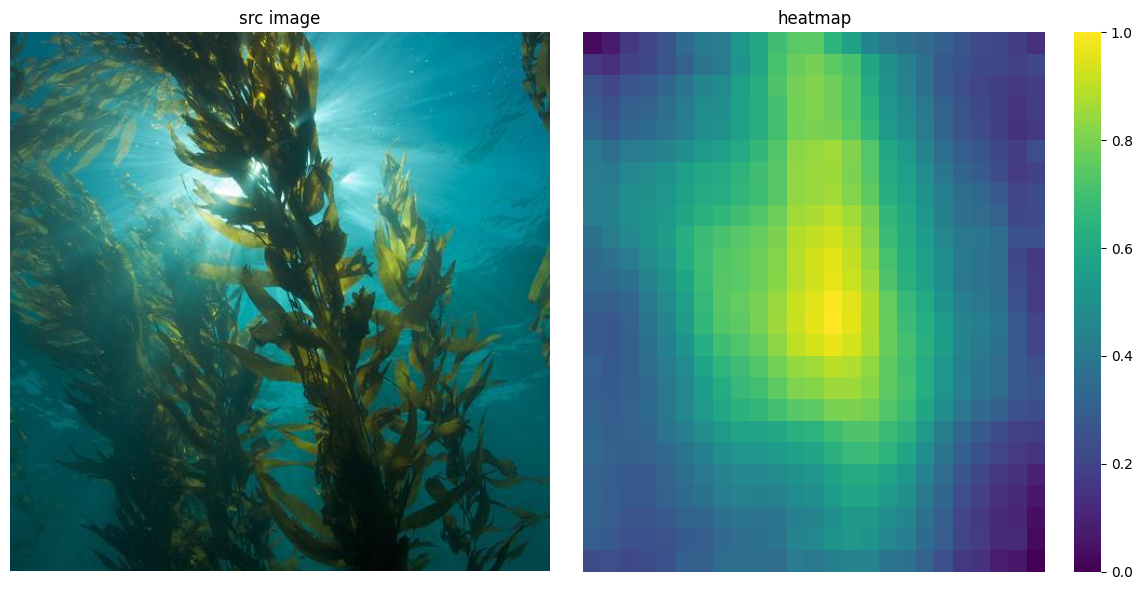

In [303]:
idx = 14
data_dir = '/dev/shm/wht/datasets/things-eeg-small/Preprocessed_data_1000Hz_whiten'
src_img = Image.open(os.path.join(data_dir,'../Image_set',img_path[idx])).convert("RGB")
src_z  = img_features[idx].unsqueeze(0).to(device)
height = 100
width = 100

eeg_tensor  = eeg[idx].unsqueeze(0).to(device)
eeg_z = pl_model.eeg(eeg_tensor)

# eeg_z =  torch.ones_like(eeg_z)
eeg_z = src_z
# eeg_z = torch.randn_like(eeg_z)
eeg_z = eeg_z/eeg_z.norm(dim=-1, keepdim=True)
heatmap = np.zeros((src_img.width,src_img.height)) 
similarity_counts = np.zeros((src_img.width,src_img.height))
margin = 20
list1 = list(range(0, src_img.width-width, margin))
list1.append(src_img.width-width)
for x in list1:
    list2 = list(range(0, src_img.height-height, margin))
    list2.append(src_img.height-height)
    for y in list2:
        img = src_img.copy()
        draw = ImageDraw.Draw(img)
        top_left = (x, y)
        bottom_right = (top_left[0]+width, top_left[1]+height)
        draw.rectangle([top_left, bottom_right], fill=(255, 255, 255))
        # bottom_right = (top_left[0] + width, top_left[1] + height)
        # white_img = Image.new("RGB", img.size, (255, 255, 255))
        # cropped_region = img.crop([top_left[0], top_left[1], bottom_right[0], bottom_right[1]])
        # white_img.paste(cropped_region, (top_left[0], top_left[1]))
        # img = white_img
        
        img_tensor = T(img).unsqueeze(0)
        img_tensor = img_tensor.to(device)
        img_z = vlmodel.encode_image(img_tensor)
        img_z = img_z/img_z.norm(dim=-1, keepdim=True)
        similarity = (eeg_z @ img_z.T)[0][0].item()

        heatmap[x:x + width,y:y + height] += similarity
        similarity_counts[x:x + width,y:y + height] += 1  
heatmap /= similarity_counts

re_heatmap = 1 - heatmap
minV = np.min(re_heatmap)
maxV = np.max(re_heatmap)
z_score_heatmap = (re_heatmap - minV)/(maxV-minV)
# z_score_heatmap[50:150, 100:150] = 1.0
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(src_img)
axes[0].axis('off')
axes[0].set_title("src image")

sns.heatmap(z_score_heatmap.T, cmap='viridis', cbar=True, ax=axes[1]) #cubehelix viridis plasma
axes[1].axis('off')
axes[1].set_title("heatmap")
plt.tight_layout()
plt.savefig(f'figures/comparison_image_heatmap_{idx}.png', dpi=300, bbox_inches='tight')

In [ ]:
src_img

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# heatmap_img = Image.fromarray(z_score_heatmap, mode='L').convert('RGBA')
# heatmap_img

In [ ]:
minV

In [ ]:
vlmodel.encode_image(img_tensor)